# Lab: Shrinkage Methods

This chapter follows closely chapter 6 of James et al. (2023).

In [3]:
pip install ISLP

Note: you may need to restart the kernel to use updated packages.


In [4]:
# Remove warnings
import warnings
warnings.filterwarnings('ignore')

In [5]:
pip install "numpy<2.0" 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.8/15.8 MB 99.6 MB/s  0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for numpy: filename=numpy-1.26.4-cp313-cp313-linux_x86_64.whl size=7039468 sha256=97301e4350c269fcec8d18f8422f34ee7f2998257ba311b17e63e8fc8ebfad2d
  Stored in directory: /home/onyxia/.cache/pip/wheels/8b/2d/9f/b6b46373f328e2ef50388915d351ccacbedac929459b5459bf
Successfully built numpy
  Attempting uninstall: numpy
    Found existing installation: numpy 2.3.4
    Uninstalling numpy-2.3.4:
      Successfully uninstalled numpy-2.3.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain-community 0.3.31 requires numpy>=2.1.0; python_version >= "3.13", but you have numpy 1.26.4 which is incompat

In [6]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
from statsmodels.api import OLS
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.preprocessing import StandardScaler
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from functools import partial


We again collect the new imports
needed for this lab.

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from ISLP.models import \
     (Stepwise,
      sklearn_selected,
      sklearn_selection_path)
#!pip install l0bnb
#from l0bnb import fit_path


When we talk about big data, we do not only talk about larger sample size ($n$), but also about a larger number of dependant variables ($p$). However, with OLS, we are limited by the identification constraint that $p<n$. In addition, we would like to have $p$ way smaller than $n$ for inference and prediction accuracy.


This lab presents methods to use a least squares fit in a setting in which the number of dependent variables,$p$, is large with respect to the sample size, $n$. 


## Shrinkage methods

Model selection methods constrained the number of varaibles *before* running a linear regression. Shrinkage methods try to run a linear regression while constraining the number of covariates/predictor variables. In particular they penalize high values of the parameters in the objective function resulting in shrunken coefficients.

We will use the `sklearn.linear_model` package (for which
we use `skl` as shorthand below)
to fit ridge and  lasso regularized linear models on the `Hitters` data.
We start with the model matrix `X` (without an intercept) that we computed in the previous section on best subset regression.
 
We will  apply shrinkage methods to the  `Hitters` 
data.  We wish to predict a baseball player’s `Salary` on the
basis of various statistics associated with performance in the
previous year.

First of all, we note that the `Salary` variable is missing for
some of the players.  The `np.isnan()`  function can be used to
identify the missing observations. It returns an array
of the same shape as the input vector, with a `True` for any elements that
are missing, and a `False` for non-missing elements.  The
`sum()`  method can then be used to count all of the
missing elements.

In [106]:
Hitters = load_data('Hitters')
np.isnan(Hitters['Salary']).sum()


59

In [107]:
Hitters.shape

(322, 20)

 We see that `Salary` is missing for 59 players. The
`dropna()`  method of data frames removes all of the rows that have missing
values in any variable (by default --- see  `Hitters.dropna?`).
Note: we are dropping the missing, but it is not always the best option. For instance in case of differential attrition.

In [108]:
Hitters = Hitters.dropna();
Hitters.shape


(263, 20)

We will fit the biggest model, using all the variables. Here we excluded the first column corresponding to the intercept, since the methods we will use will fit the intercept separately:

In [109]:
design = MS(Hitters.columns.drop('Salary')).fit(Hitters)
Y = np.array(Hitters['Salary'])
D = design.fit_transform(Hitters)
D = D.drop('intercept', axis=1)
X = np.asarray(D)


## Shrinkage methods



### Ridge Regression

Recall that the Ridge Regression objective function is: 
$$ \hat{\beta}^{R}= arg min_{\beta} \sum_{i=1}^{n}(y_{i} - \beta_{0} - \sum_{j=1}^{p} \beta_{j}x_{ij})^2 + \lambda \sum_{j=1}^p \beta^{2}_{j}  = RSS + \lambda \sum_{j=1}^p \beta^{2}_{j} $$
with $\lambda>0$ is a tuning parameter regulating the penalties applied on large parameter.


We will use the function `skl.ElasticNet()` to fit both  ridge and the lasso.
To fit a *path* of ridge regressions models, we use
`skl.ElasticNet.path()`, which can fit both ridge and lasso, as well as a hybrid mixture;  ridge regression
corresponds to `l1_ratio=0`.
It is good practice to standardize the columns of `X` in these applications, why? The main reason is that if variables are measured in different units, those with higher values could be perceived as having higher contributions to the model while it is not the case. Since `skl.ElasticNet()` **does not do normalization**, we have to take care of that ourselves.

Since we standardize first, in order to find coefficient
estimates on the original scale, we must *unstandardize*
the coefficient estimates. The parameter $\lambda$ in $RSS + \lambda \sum^{p}_{j=1}\beta^{2}_{j}$ (Ridge 6.5) and $RSS + \lambda \sum^{p}_{j=1}| \beta_{j}| $ (Lasso 6.7) is called `alphas` in `sklearn`. In order to
be consistent with the rest of this chapter, we use `lambdas`
rather than `alphas` in what follows. 

In [110]:
#Standardize in the first 3 rows
Xs = X - X.mean(0)[None,:]
X_scale = X.std(0)
Xs = Xs / X_scale[None,:]
#Compute the lambdas
lambdas = 10**np.linspace(8, -2, 100) / Y.std() #Creates a logarithmic grid between 10**8/sd(Y) et 10**−2/sd(Y).
#Apply ridge regression
soln_array = skl.ElasticNet.path(Xs,
                                 Y,
                                 l1_ratio=0.,
                                 alphas=lambdas)[1]
soln_array.shape


(19, 100)

Here we extract the array of coefficients corresponding to the solutions along the regularization path.

By default the `skl.ElasticNet.path` method fits a path along
an automatically selected range of $\lambda$ values, except for the case when
`l1_ratio=0`, which results in ridge regression (as is the case here). {The reason is rather technical; for all models except ridge, we can find the smallest value of $\lambda$ for which all coefficients are zero. For ridge this value is $\infty$.}  

So here we have chosen to implement the function over a grid of values ranging
from $\lambda=10^{8}$ to $\lambda=10^{-2}$ scaled by the standard
deviation of $y$, essentially covering the full range of scenarios
from the null model containing only the intercept, to the least
squares fit.

Associated with each value of $\lambda$ is a vector of ridge
regression coefficients,   that can be accessed by
a column of `soln_array`. In this case, `soln_array` is a $19 \times 100$ matrix, with
19 rows (one for each predictor) and 100
columns (one for each value of $\lambda$).

We transpose this matrix and turn it into a data frame to facilitate viewing and plotting.

In [111]:
soln_path = pd.DataFrame(soln_array.T,
                         columns=D.columns,
                         index=-np.log(lambdas)) #use neg log to have a readable and intuitive scale later in the graph.
soln_path.index.name = 'negative log(lambda)' #positive values of lambda (higher penalization) have negative values of negative log lambda and conversely. 
soln_path


,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League[N],Division[W],PutOuts,Assists,Errors,NewLeague[N]
negative log(lambda),,,,,,,,,,,,,,,,,,,
-12.310855,0.000800,0.000889,0.000695,0.000851,0.000911,0.000900,0.000812,0.001067,0.001113,0.001064,0.001141,0.001149,0.000993,-0.000029,-0.000390,0.000609,0.000052,-0.000011,-0.000006
-12.078271,0.001010,0.001122,0.000878,0.001074,0.001150,0.001135,0.001025,0.001346,0.001404,0.001343,0.001439,0.001450,0.001253,-0.000037,-0.000492,0.000769,0.000065,-0.000014,-0.000007
-11.845686,0.001274,0.001416,0.001107,0.001355,0.001451,0.001433,0.001293,0.001698,0.001772,0.001694,0.001816,0.001830,0.001581,-0.000046,-0.000621,0.000970,0.000082,-0.000017,-0.000009
-11.613102,0.001608,0.001787,0.001397,0.001710,0.001831,0.001808,0.001632,0.002143,0.002236,0.002138,0.002292,0.002309,0.001995,-0.000058,-0.000784,0.001224,0.000104,-0.000022,-0.000012
-11.380518,0.002029,0.002255,0.001763,0.002158,0.002310,0.002281,0.002059,0.002704,0.002821,0.002698,0.002892,0.002914,0.002517,-0.000073,-0.000990,0.001544,0.000131,-0.000028,-0.000015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9.784658,-290.823989,336.929968,37.322686,-59.748520,-26.507086,134.855915,-17.216195,-387.775826,89.573601,-12.273926,476.079273,257.271255,-213.124780,31.258215,-58.457857,78.761266,53.622113,-22.208456,-12.402891
10.017243,-290.879272,337.113713,37.431373,-59.916820,-26.606957,134.900549,-17.108041,-388.458404,89.000707,-12.661459,477.031349,257.966790,-213.280891,31.256434,-58.448850,78.761240,53.645147,-22.198802,-12.391969
10.249827,-290.923382,337.260446,37.518064,-60.051166,-26.686604,134.936136,-17.022194,-388.997470,88.537380,-12.971603,477.791860,258.523025,-213.405740,31.254958,-58.441682,78.761230,53.663357,-22.191071,-12.383205


We plot the paths to get a sense of how the coefficients vary with $\lambda$.
To control the location of the legend we first set `legend` to `False` in the
plot method, adding it afterward with the `legend()` method of `ax`.

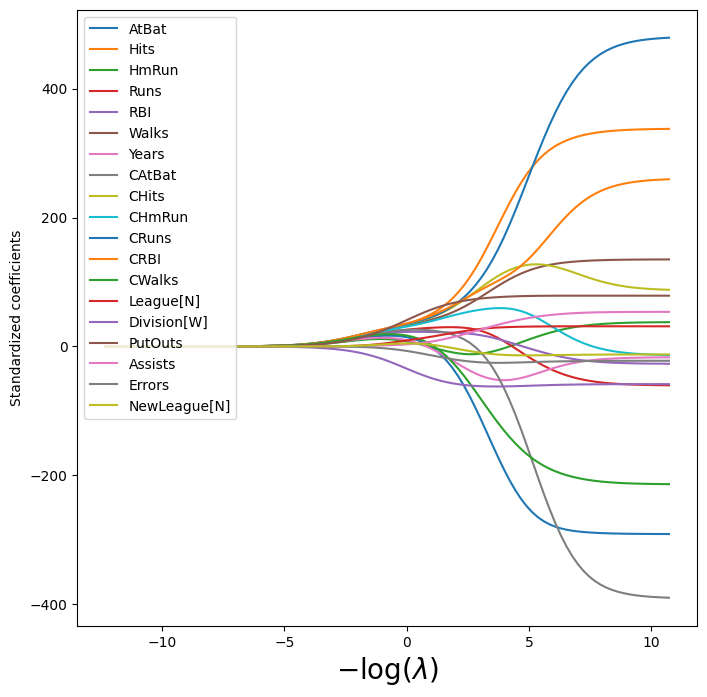

In [112]:
path_fig, ax = subplots(figsize=(8,8))
soln_path.plot(ax=ax, legend=False)
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Standardized coefficients', fontsize=10)
ax.legend(loc='upper left');


(We have used `latex` formatting in the horizontal label, in order to format the Greek $\lambda$ appropriately.) 
We expect the coefficient estimates to be much smaller, in terms of
$\ell_2$ norm, when a large value of $\lambda$ is used, as compared to
when a small value of $\lambda$ is used. (Recall that the  $\ell_2$ norm is the square root of the sum of squared coefficient values.) We display  the coefficients at the $40$th step,
where $\lambda$ is 25.535.

In [113]:
beta_hat = soln_path.loc[soln_path.index[39]]
lambdas[39], beta_hat


(25.53538897200662,
 AtBat           5.433750
 Hits            6.223582
 HmRun           4.585498
 Runs            5.880855
 RBI             6.195921
 Walks           6.277975
 Years           5.299767
 CAtBat          7.147501
 CHits           7.539495
 CHmRun          7.182344
 CRuns           7.728649
 CRBI            7.790702
 CWalks          6.592901
 League[N]       0.042445
 Division[W]    -3.107159
 PutOuts         4.605263
 Assists         0.378371
 Errors         -0.135196
 NewLeague[N]    0.150323
 Name: -3.240065292879872, dtype: float64)

Let’s compute the $\ell_2$ norm of the standardized coefficients.

In [114]:
np.linalg.norm(beta_hat)


24.170617201443775

In contrast, here is the $\ell_2$ norm when $\lambda$ is 2.44e-01.
Note the much larger $\ell_2$ norm of the
coefficients associated with this smaller value of $\lambda$.

In [115]:
beta_hat = soln_path.loc[soln_path.index[59]]
lambdas[59], np.linalg.norm(beta_hat)


(0.2437476613348855, 160.42371017725927)

Above we normalized `X` upfront, and fit the ridge model using `Xs`.
The `Pipeline()`  object
in `sklearn` provides a clear way to separate feature
normalization from the fitting of the ridge model itself.

In [116]:
ridge = skl.ElasticNet(alpha=lambdas[59], l1_ratio=0)
scaler = StandardScaler(with_mean=True,  with_std=True)
pipe = Pipeline(steps=[('scaler', scaler), ('ridge', ridge)])
pipe.fit(X, Y)


,steps,"[('scaler', ...), ('ridge', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,alpha,0.2437476613348855
,l1_ratio,0
,fit_intercept,True
,precompute,False


We show that it gives the same $\ell_2$ norm as in our previous fit on the standardized data.

In [117]:
np.linalg.norm(ridge.coef_)


160.42371017725912

 Notice that the operation `pipe.fit(X, Y)` above has changed the `ridge` object, and in particular has added attributes such as `coef_` that were not there before. 


In [38]:
dir(ridge)

['_ElasticNet__metadata_request__fit',
 '__abstractmethods__',
 '__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__firstlineno__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__sklearn_clone__',
 '__sklearn_tags__',
 '__static_attributes__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_build_request_for_signature',
 '_decision_function',
 '_doc_link_module',
 '_doc_link_template',
 '_doc_link_url_param_generator',
 '_estimator_type',
 '_get_default_requests',
 '_get_doc_link',
 '_get_metadata_request',
 '_get_param_names',
 '_get_params_html',
 '_html_repr',
 '_parameter_constraints',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_set_intercept',
 '_validate_params',
 'a

In [ ]:
print(ridge.coef_)

### Estimating Test Error of Ridge Regression
Choosing an *a priori* value of $\lambda$ for ridge regression is
difficult if not impossible. We will want to use the validation method
or cross-validation to select the tuning parameter.

We fix the random state of the splitter
so that the results obtained will be reproducible.

In [118]:
validation = skm.ShuffleSplit(n_splits=1,
                              test_size=0.5,
                              random_state=17092023)
ridge.alpha = 0.01
results = skm.cross_validate(ridge,
                             X,
                             Y,
                             scoring='neg_mean_squared_error',
                             cv=validation)
-results['test_score']


array([147613.45831137])

The test MSE is 1.47e+05.  Note
that if we had instead simply fit a model with just an intercept, we
would have predicted each test observation using the mean of the
training observations. We can get the same result by fitting a ridge regression model
with a *very* large value of $\lambda$. Note that `1e10`
means $10^{10}$.

In [119]:
ridge.alpha = 1e10
results = skm.cross_validate(ridge,
                             X,
                             Y,
                             scoring='neg_mean_squared_error',
                             cv=validation)
-results['test_score']


array([203351.3961087])

Obviously choosing $\lambda=0.01$ is arbitrary,  so we will  use cross-validation or the validation-set
approach to choose the tuning parameter $\lambda$.
The object `GridSearchCV()`  allows exhaustive
grid search to choose such a parameter.

We first use the validation set method
to choose $\lambda$.

In [120]:
param_grid = {'ridge__alpha': lambdas}
grid = skm.GridSearchCV(pipe,
                        param_grid,
                        cv=validation,
                        scoring='neg_mean_squared_error')
grid.fit(X, Y)
grid.best_params_['ridge__alpha']
grid.best_estimator_


,steps,"[('scaler', ...), ('ridge', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,alpha,1.241684227628628
,l1_ratio,0
,fit_intercept,True
,precompute,False


Alternatively, we can use 5-fold cross-validation.

In [121]:
K = 5
kfold = skm.KFold(K,
                  random_state=0,
                  shuffle=True)

grid = skm.GridSearchCV(pipe, 
                        param_grid,
                        cv=kfold,
                        scoring='neg_mean_squared_error')
grid.fit(X, Y)
grid.best_params_['ridge__alpha']
grid.best_estimator_


,steps,"[('scaler', ...), ('ridge', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,alpha,0.011852477631442489
,l1_ratio,0
,fit_intercept,True
,precompute,False


We now plot the cross-validated MSE as a function of $-\log(\lambda)$, which has shrinkage decreasing from left
to right.

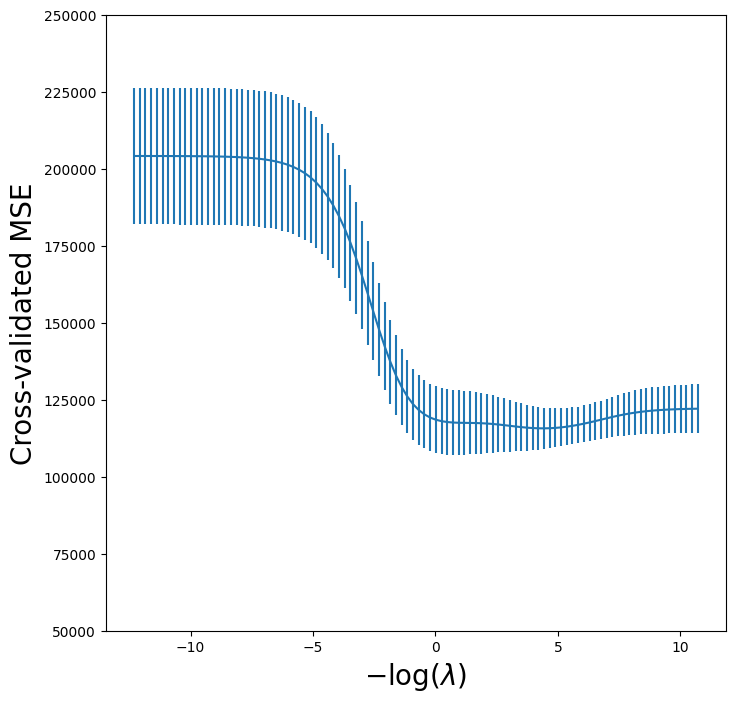

In [122]:
ridge_fig, ax = subplots(figsize=(8,8))
ax.errorbar(-np.log(lambdas),
            -grid.cv_results_['mean_test_score'],
            yerr=grid.cv_results_['std_test_score'] / np.sqrt(K))
ax.set_ylim([50000,250000])
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated MSE', fontsize=20);


One can cross-validate different metrics to choose a parameter. The default
metric for `skl.ElasticNet()` is test $R^2$.
Let’s compare $R^2$ to MSE for cross-validation here.

In [123]:
grid_r2 = skm.GridSearchCV(pipe, 
                           param_grid,
                           cv=kfold)
grid_r2.fit(X, Y)


,estimator,Pipeline(step...l1_ratio=0))])
,param_grid,{'ridge__alpha': array([2.2209...22093791e-05])}
,scoring,None
,n_jobs,None
,refit,True
,cv,KFold(n_split... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


Finally, let’s plot the results for cross-validated $R^2$.

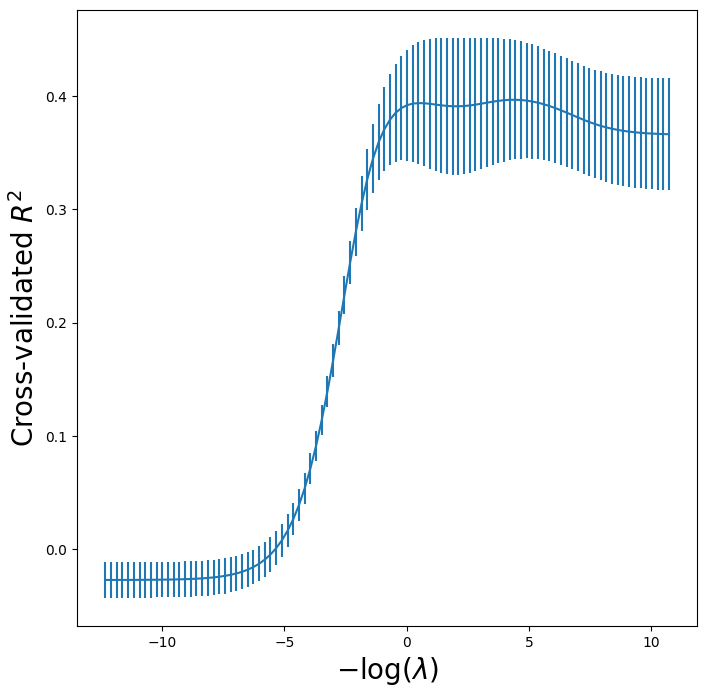

In [124]:
r2_fig, ax = subplots(figsize=(8,8))
ax.errorbar(-np.log(lambdas),
            grid_r2.cv_results_['mean_test_score'],
            yerr=grid_r2.cv_results_['std_test_score'] / np.sqrt(K))
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated $R^2$', fontsize=20);


### Fast Cross-Validation for Solution Paths
The ridge, lasso, and elastic net can be efficiently fit along a sequence of $\lambda$ values, creating what is known as a *solution path* or *regularization path*. Hence there is specialized code to fit
such paths, and to choose a suitable value of $\lambda$ using cross-validation. 

Even with identical splits the results will not agree *exactly* with our `grid`
above because the standardization of each feature  in `grid` is carried out on each fold,
while in `pipeCV` below it is carried out only once.
Nevertheless, the results are similar as the normalization
is relatively stable across folds.

In [125]:
ridgeCV = skl.ElasticNetCV(alphas=lambdas, 
                           l1_ratio=0,
                           cv=kfold)
pipeCV = Pipeline(steps=[('scaler', scaler),
                         ('ridge', ridgeCV)])
pipeCV.fit(X, Y)


,steps,"[('scaler', ...), ('ridge', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,l1_ratio,0
,eps,0.001
,n_alphas,'deprecated'
,alphas,array([2.2209...22093791e-05])


Let’s produce a plot again of the cross-validation error to see that
it is similar to using `skm.GridSearchCV`.

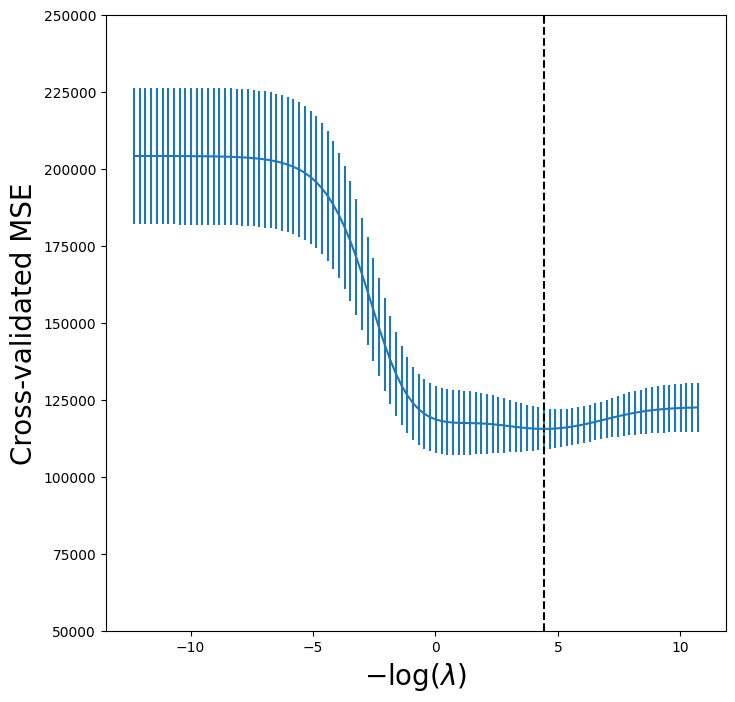

In [126]:
tuned_ridge = pipeCV.named_steps['ridge'] #Calls the ridge step in pipeCV
ridgeCV_fig, ax = subplots(figsize=(8,8))
ax.errorbar(-np.log(lambdas),
            tuned_ridge.mse_path_.mean(1),
            yerr=tuned_ridge.mse_path_.std(1) / np.sqrt(K))
ax.axvline(-np.log(tuned_ridge.alpha_), c='k', ls='--')
ax.set_ylim([50000,250000])
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated MSE', fontsize=20);


We see that the value of $\lambda$ that results in the
smallest cross-validation error is 1.115e-02, available
as the value `tuned_ridge.alpha_`. What is the test MSE
associated with this value of $\lambda$?

In [127]:
np.min(tuned_ridge.mse_path_.mean(1))


115526.70630987734

Note: In this line of code the function `np.min()` returns the lowest value of the MSE for all values of $\lambda$ in our search grid.

This represents a further improvement over the test MSE that we got
using $\lambda=0.01$.  Finally, `tuned_ridge.coef_`
has the coefficients fit on the entire data set
at this value of  $\lambda$.

In [128]:
tuned_ridge.coef_


array([-222.80877051,  238.77246614,    3.21103754,   -2.93050845,
          3.64888723,  108.90953869,  -50.81896152, -105.15731984,
        122.00714801,   57.1859509 ,  210.35170348,  118.05683748,
       -150.21959435,   30.36634231,  -61.62459095,   77.73832472,
         40.07350744,  -25.02151514,  -13.68429544])

As expected, none of the coefficients are zero—ridge regression does
not perform variable selection!

### Evaluating Test Error of Cross-Validated Ridge
Choosing $\lambda$ using cross-validation provides a single regression
estimator, similar to fitting a linear regression model. It is therefore reasonable to estimate what its test error is. 

We run into a problem here in that cross-validation will have
*touched* all of its data in choosing $\lambda$, hence we have no
further data to estimate test error.

A compromise is to do an initial
split of the data into two disjoint sets: a training set and a test set.
We then fit a cross-validation
tuned ridge regression on the training set, and evaluate its performance on the test set.

We might call this cross-validation nested
within the validation set approach. A priori there is no reason to use
half of the data for each of the two sets in validation. Below, we use
75% for training and 25% for test, with the estimator being ridge
regression tuned using 5-fold cross-validation.  This can be achieved
in code as follows:

In [129]:
outer_valid = skm.ShuffleSplit(n_splits=1, 
                               test_size=0.25,
                               random_state=1)
inner_cv = skm.KFold(n_splits=5,
                     shuffle=True,
                     random_state=2)
ridgeCV = skl.ElasticNetCV(alphas=lambdas,
                           l1_ratio=0,
                           cv=inner_cv)
pipeCV = Pipeline(steps=[('scaler', scaler),
                         ('ridge', ridgeCV)]);


In [130]:
results = skm.cross_validate(pipeCV, 
                             X,
                             Y,
                             cv=outer_valid,
                             scoring='neg_mean_squared_error')
-results['test_score']


array([132393.84003227])

### The Lasso

Lasso coefficients minimize the following objective function: 

   $$ \beta_{L}= arg min_{\beta} \sum_{i=1}^{n}(y_{i} - \beta_{0} - \sum_{j=1}^{p} \beta_{j}x_{ij})^2 + \lambda \sum_{j=1}^p |\beta_{j}| $$

A consequence of this objective function is that Lasso is much more likely to shrink coefficients to exactly zero, performing variable selection. 



We saw that ridge regression with a wise choice of $\lambda$ can
outperform least squares as well as the null model on the
 `Hitters`  data set. We now ask whether the lasso can yield
either a more accurate or a more interpretable model than ridge
regression. In order to fit a lasso model, we once again use the
`ElasticNetCV()`  function; however, this time we use the argument
`l1_ratio=1`. Other than that change, we proceed just as we did in
fitting a ridge model.

In [131]:
lassoCV = skl.ElasticNetCV(n_alphas=100, 
                           l1_ratio=1,
                           cv=kfold)
pipeCV = Pipeline(steps=[('scaler', scaler),
                         ('lasso', lassoCV)])
pipeCV.fit(X, Y)
tuned_lasso = pipeCV.named_steps['lasso']
tuned_lasso.alpha_


3.1472370031649866

In [132]:
lambdas, soln_array = skl.Lasso.path(Xs, 
                                    Y,
                                    l1_ratio=1,
                                    n_alphas=100)[:2]
soln_path = pd.DataFrame(soln_array.T,
                         columns=D.columns,
                         index=-np.log(lambdas))


We can see from the coefficient plot of the standardized coefficients that depending on the choice of
tuning parameter, some of the coefficients will be exactly equal to
zero.

In [133]:
soln_path

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League[N],Division[W],PutOuts,Assists,Errors,NewLeague[N]
-5.542369,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000
-5.472594,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,17.205159,0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000
-5.402819,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,33.250748,0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000
-5.333043,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,6.545671,42.024827,0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000
-5.263268,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,13.727251,49.189007,0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1.086285,-292.618320,330.147359,25.671504,-49.562410,-13.598973,130.583914,-24.123416,-286.579896,31.226178,-0.0,452.829429,229.229316,-209.493673,28.373513,-58.125944,79.096546,49.338699,-20.820927,-9.515995
1.156060,-292.511837,330.496934,26.317012,-50.124459,-14.357879,130.849065,-23.603337,-294.116322,37.120221,-0.0,453.537777,229.848245,-209.616048,28.584855,-58.145706,79.080585,49.655372,-20.923792,-9.725398
1.225835,-292.413043,330.823484,26.918970,-50.648775,-15.065567,131.096456,-23.118630,-301.141293,42.613785,-0.0,454.198913,230.425310,-209.730604,28.781925,-58.164143,79.065724,49.950637,-21.019700,-9.920665
1.295611,-292.320279,331.127368,27.480414,-51.137572,-15.725645,131.327039,-22.666199,-307.697118,47.741074,-0.0,454.814838,230.963666,-209.836915,28.965748,-58.181330,79.051835,50.226081,-21.109174,-10.102799


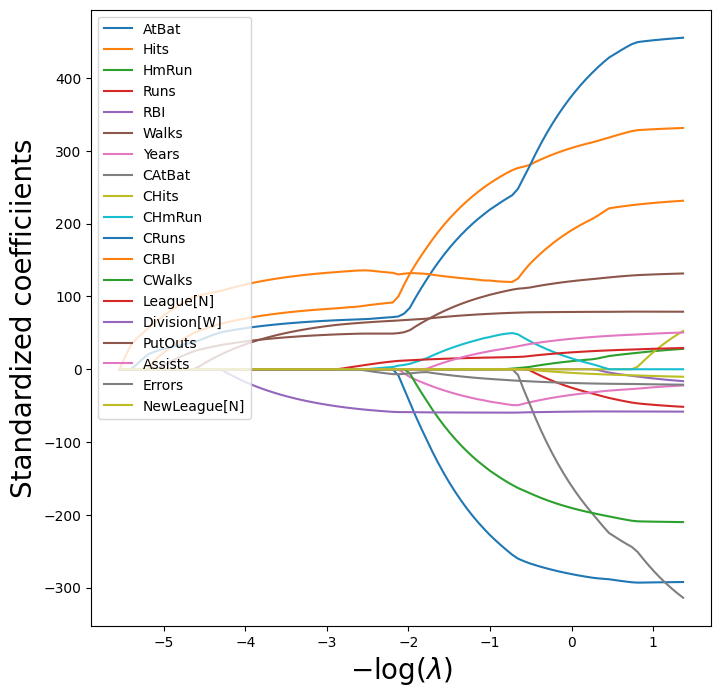

In [134]:
path_fig, ax = subplots(figsize=(8,8))
soln_path.plot(ax=ax, legend=False)
ax.legend(loc='upper left')
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Standardized coefficiients', fontsize=20);


The smallest cross-validated error is lower than the test set MSE of the null model
and of least squares, and very similar to the test MSE of 115526.71 of ridge
regression  with $\lambda$ chosen by cross-validation.

In [135]:
np.min(tuned_lasso.mse_path_.mean(1))


114690.73118253695

Let’s again produce a plot of the cross-validation error.


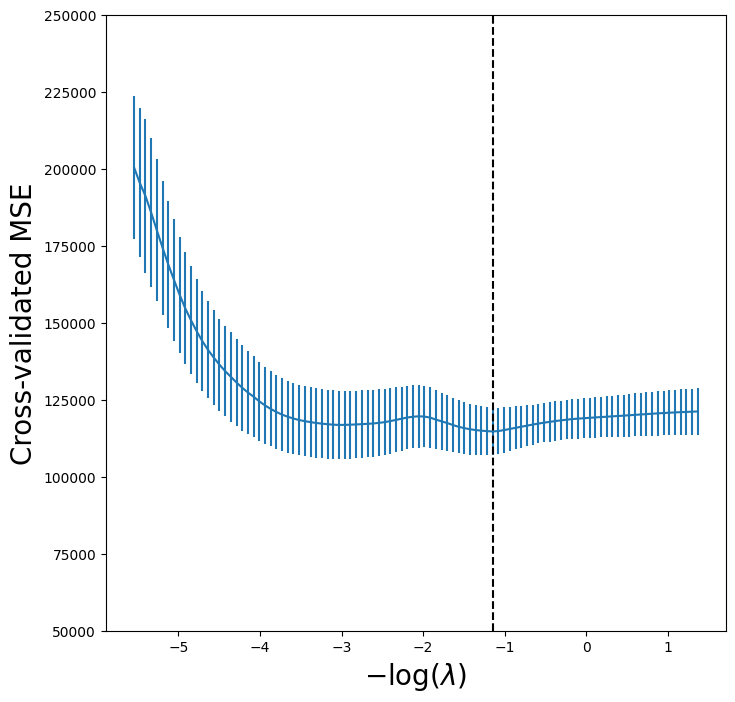

In [136]:
lassoCV_fig, ax = subplots(figsize=(8,8))
ax.errorbar(-np.log(tuned_lasso.alphas_),
            tuned_lasso.mse_path_.mean(1),
            yerr=tuned_lasso.mse_path_.std(1) / np.sqrt(K))
ax.axvline(-np.log(tuned_lasso.alpha_), c='k', ls='--')
ax.set_ylim([50000,250000])
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated MSE', fontsize=20);

However, the lasso has a substantial advantage over ridge regression
in that the resulting coefficient estimates are **sparse**. Here we see
that 6 of the 19 coefficient estimates are exactly zero. So the lasso
model with $\lambda$ chosen by cross-validation contains only 13
variables.

In [137]:
tuned_lasso.coef_


array([-210.01008773,  243.4550306 ,    0.        ,    0.        ,
          0.        ,   97.69397357,  -41.52283116,   -0.        ,
          0.        ,   39.62298193,  205.75273856,  124.55456561,
       -126.29986768,   15.70262427,  -59.50157967,   75.24590036,
         21.62698014,  -12.04423675,   -0.        ])

As in ridge regression, we could evaluate the test error
of cross-validated lasso by first splitting into
test and training sets and internally running
cross-validation on the training set. 

## Exercise 1

In this exercise, we will predict the number of applications received using the other variables in the `College` data set:

- (a) Split the data set into a training set and a test set.

- (b) Fit a linear model using least squares on the training set, and report the test error obtained.

- (c) Fit a ridge regression model on the training set, with `lambda` chosen by cross-validation. Report the test error obtained.

- (d) Fit a lasso model on the training set, with `lambda` chosen by crossvalidation. Report the test error obtained, along with the number of non-zero coefficient estimates.

- (e) Comment on the results obtained. How accurately can we predict the number of college applications received? Is there much difference among the test errors resulting from these three approaches?

(a) Split the data set into a training set and a test set.

In [181]:
# Import required packages
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from ISLP.models import summarize

# Import data
College = load_data('College')
College.describe()

,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
count,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.00000
mean,3001.638353,2018.804376,779.972973,27.558559,55.796654,3699.907336,855.298584,10440.669241,4357.526384,549.380952,1340.642214,72.660232,79.702703,14.089704,22.743887,9660.171171,65.46332
std,3870.201484,2451.113971,929.176190,17.640364,19.804778,4850.420531,1522.431887,4023.016484,1096.696416,165.105360,677.071454,16.328155,14.722359,3.958349,12.391801,5221.768440,17.17771
min,81.000000,72.000000,35.000000,1.000000,9.000000,139.000000,1.000000,2340.000000,1780.000000,96.000000,250.000000,8.000000,24.000000,2.500000,0.000000,3186.000000,10.00000
25%,776.000000,604.000000,242.000000,15.000000,41.000000,992.000000,95.000000,7320.000000,3597.000000,470.000000,850.000000,62.000000,71.000000,11.500000,13.000000,6751.000000,53.00000
50%,1558.000000,1110.000000,434.000000,23.000000,54.000000,1707.000000,353.000000,9990.000000,4200.000000,500.000000,1200.000000,75.000000,82.000000,13.600000,21.000000,8377.000000,65.00000
75%,3624.000000,2424.000000,902.000000,35.000000,69.000000,4005.000000,967.000000,12925.000000,5050.000000,600.000000,1700.000000,85.000000,92.000000,16.500000,31.000000,10830.000000,78.00000
max,48094.000000,26330.000000,6392.000000,96.000000,100.000000,31643.000000,21836.000000,21700.000000,8124.000000,2340.000000,6800.000000,103.000000,100.000000,39.800000,64.000000,56233.000000,118.00000


In [182]:
#Create y and X and split data
X = College.drop(columns='Apps')
X = pd.get_dummies(X, drop_first=True)  # Transform categorical variables into dummies for standardization
y = College['Apps']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=12345)

X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 777 entries, 0 to 776
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Accept       777 non-null    int64  
 1   Enroll       777 non-null    int64  
 2   Top10perc    777 non-null    int64  
 3   Top25perc    777 non-null    int64  
 4   F.Undergrad  777 non-null    int64  
 5   P.Undergrad  777 non-null    int64  
 6   Outstate     777 non-null    int64  
 7   Room.Board   777 non-null    int64  
 8   Books        777 non-null    int64  
 9   Personal     777 non-null    int64  
 10  PhD          777 non-null    int64  
 11  Terminal     777 non-null    int64  
 12  S.F.Ratio    777 non-null    float64
 13  perc.alumni  777 non-null    int64  
 14  Expend       777 non-null    int64  
 15  Grad.Rate    777 non-null    int64  
 16  Private_Yes  777 non-null    bool   
dtypes: bool(1), float64(1), int64(15)
memory usage: 98.0 KB


In [183]:
# Standardize predictors in each subset
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


(b) Fit a linear model using least squares on the training set, and report the test error obtained.

In [184]:
# Transform data
X_train_std = sm.add_constant(X_train_scaled)  # add_intercept
X_test_std = sm.add_constant(X_test_scaled)

# Fit model and predict
model = sm.OLS(y_train, X_train_std)
results = model.fit()
test_pred = results.predict(X_test_std)
np.mean((y_test - test_pred)**2)

768454.3476874873

(c) Fit a ridge regression model on the training set, with lambda chosen by cross-validation. Report the test error obtained.

In [188]:
# Create search grid for tuning parameter (lambda)
lambdas = 10**np.linspace(8, -2, 100) / y.std()

# Choose splitting rule for outer split (train set vs. test set)
outer_valid = skm.ShuffleSplit(n_splits=1, 
                               test_size=0.33,
                               random_state=12345)

# Choose splitting rule for cross-validation step (used to select optimal lambda)
inner_cv = skm.KFold(n_splits=5,
                     shuffle=True,
                     random_state=1)

# Program ridge regression with lambda selected based on inner_CV
ridgeCV = skl.ElasticNetCV(alphas=lambdas,
                           l1_ratio=0,
                           cv=inner_cv)

# Standardize predictors
pipeCV = Pipeline(steps=[('scaler', scaler),
                         ('ridge', ridgeCV)])

# Obtain MSE from validation set using outer split
results = skm.cross_validate(pipeCV, 
                             X,
                             y,
                             cv=outer_valid,
                             scoring='neg_mean_squared_error')

-results['test_score'] # need to print the negative of the test score because cross_validate function works by maximizing the negative mean squared error (equivalent to minimizing the MSE).




array([768443.83345726])

(d) Fit a lasso model on the training set, with lambda chosen by crossvalidation. Report the test error obtained, along with the number of non-zero coefficient estimates.

In [192]:
# Program lasso regression with lambda selected based on inner_CV
lassoCV = skl.ElasticNetCV(alphas=lambdas,
                           l1_ratio=1,
                           cv=inner_cv)

# Standardize predictors
pipeCV = Pipeline(steps=[('scaler', scaler),
                         ('lasso', lassoCV)])

# Obtain MSE from validation set using outer split
results = skm.cross_validate(pipeCV, 
                             X,
                             y,
                             cv=outer_valid,
                             scoring='neg_mean_squared_error')

print(-results['test_score']) # need to print the negative of the test score because cross_validate function works by maximizing the negative mean squared error (equivalent to minimizing the MSE).

# Fit the pipeline on the whole dataset to get more stable coefficients
pipeCV.fit(X, y)
coeffs = pipeCV.named_steps['lasso'].coef_

# Count the number of non-zero coefficients
n_nonzero = np.sum(coeffs != 0)

print(f"Number of non-zero coefficients : {n_nonzero}")


[759590.79891093]
Number of non-zero coefficients : 17


In [191]:
# Get root-MSE

rMSE = (-results['test_score'])**(1/2)
print(rMSE)

[871.54506419]


(e) Comment on the results obtained. How accurately can we predict the number of college applications received? Is there much difference among the test errors resulting from these three approaches?

The smallest MSE is obtained with the lasso method. The root-MSE is 871.5 which corresponds to 0.22 standard deviations of the Apps variable in the whole sample. This indicates that the model can predict the number of applications with a reasonable accuracy, reducing prediction error to about one-fifth of the typical variability in applications. However, the differences in test errors between the three methods are relatively small, suggesting that while lasso provides a slight improvement, ridge and standard linear regression also perform comparably.

## Exercise 2

In this exercise, we will generate simulated data, and will then use this data to perform lasso regressions:

- (a) Create a random number generator and use its `normal()` method to generate a predictor `X` of length n = 100, as well as a noise vector $\epsilon$ of length n = 100.

- (b) Generate a response vector `Y` of length n = 100 according to the model:

$$ Y = \beta_0 + \beta_1X + \beta_2X^2 + \beta_3X^3 + \epsilon $$

where $\beta_0$, $\beta_1$, $\beta_2$, and $\beta_3$ are constants of your choice.

- (c) Now fit a lasso model to the simulated data, using $X$, $X^2$, ... ,$X^{10}$ as predictors. Use cross-validation to select the optimal value of $\lambda$. Create plots of the cross-validation error as a function of $\lambda$. Report the resulting coefficient estimates, and discuss the results obtained.
  
- (d) Now generate a response vector `Z` according to the model $Z =  \beta_0 + \beta_5X^5 + \epsilon$,
and perform the lasso on it with the same predictors as before. Discuss the results obtained.

In [160]:
#Import required packages
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

**(a) Create a random number generator and use its normal() method to generate a predictor X of length n = 100, as well as a noise vector of length n = 100**

In [161]:
#Generate x and epsilon
rng = np.random.default_rng(12345)
x = rng.normal(size=100)
e = rng.normal(size=100) 

**(b) Generate a response vector `Y` of length n = 100 according to the model:**

$$ Y = \beta_0 + \beta_1X + \beta_2X^2 + \beta_3X^3 + \epsilon $$

**where $\beta_0$, $\beta_1$, $\beta_2$, and $\beta_3$ are constants of your choice.**

In [162]:
#Generate y
y = x  - 2 * x**2 + 0.5 * x**3 + rng.normal(size=100)

**(c) Now fit a lasso model to the simulated data, using $X$, $X^2$, ... ,$X^{10}$ as predictors. Use cross-validation to select the optimal value of $\lambda$. Create plots of the cross-validation error as a function of $\lambda$. Report the resulting coefficient estimates, and discuss the results obtained.**

In [163]:
# Create matrix of predictors (no need to add intercept here, it will be added by the default settings of ElasticNetCV below): 
X = np.power.outer(x, np.arange(1,11))
#print(X)

In [164]:
# Create search grid for tuning parameter (lambda)
lambdas = 10**np.linspace(8, -2, 100) / y.std()

# Choose splitting rule for outer split (train set vs. test set)
outer_valid = skm.ShuffleSplit(n_splits=1, 
                               test_size=0.25,
                               random_state=0)

# Choose splitting rule for cross-validation step (used to select optimal lambda)
inner_cv = skm.KFold(n_splits=5,
                     shuffle=True,
                     random_state=1)

# Program lasso regression with lambda selected based on inner_CV
lassoCV = skl.ElasticNetCV(alphas=lambdas,
                           l1_ratio=1,
                           cv=inner_cv)

# Standardize predictors: 
pipeCV = Pipeline(steps=[('scaler', scaler),
                         ('lasso', lassoCV)])

# Obtain MSE from validation set using outer split
results = skm.cross_validate(pipeCV, 
                             X,
                             y,
                             cv=outer_valid,
                             scoring='neg_mean_squared_error',
                             return_estimator=True) #Add this line to store estimator results (to print selected alpha below)
#Print MSE
print(-results['test_score']) 

#Print selected lambda
est = results['estimator'][0] #Store estimation results in object est and print alpha (here [0] is the index of the trained model: only 1 model trained by outer_valid, index = 0)
selected_alpha = est.named_steps['lasso'].alpha_
print("Selected λ (alpha):", selected_alpha)

[1.01988614]
Selected λ (alpha): 0.055783189022462154


In [165]:
#Collect path of solutions for all lambdas
soln_array = skl.ElasticNet.path(X,
                                 y,
                                 l1_ratio=0.,
                                 alphas=lambdas)[1]

#Generate column names for soln_path

colnames = ['X'] + [f'X^{i}' for i in range(2, 11)]


#Construct dataframe of coefficients for each lambda
soln_path = pd.DataFrame(soln_array.T,
                         columns=colnames,
                         index=-np.log(lambdas))

soln_path

,X,X^2,X^3,X^4,X^5,X^6,X^7,X^8,X^9,X^10
-17.348556,5.179913e-08,-1.036973e-07,1.033098e-07,-2.748690e-07,2.073710e-07,-9.127031e-07,2.311897e-07,-0.000004,-0.000002,-0.000017
-17.115972,6.544235e-08,-1.306285e-07,1.308916e-07,-3.454197e-07,2.651999e-07,-1.142387e-06,3.152649e-07,-0.000005,-0.000002,-0.000021
-16.883387,8.269920e-08,-1.644960e-07,1.659707e-07,-4.337033e-07,3.400033e-07,-1.427375e-06,4.335820e-07,-0.000006,-0.000002,-0.000026
-16.650803,1.045352e-07,-2.070613e-07,2.106395e-07,-5.440126e-07,4.370901e-07,-1.779858e-06,6.008785e-07,-0.000007,-0.000002,-0.000032
-16.418219,1.321763e-07,-2.605252e-07,2.675891e-07,-6.816263e-07,5.634970e-07,-2.214324e-06,8.380103e-07,-0.000009,-0.000002,-0.000040
...,...,...,...,...,...,...,...,...,...,...
4.746958,7.794825e-01,-1.838018e+00,3.902382e-01,1.353868e-01,1.691719e-02,-1.758995e-01,7.621476e-02,0.020517,-0.018911,0.003275
4.979542,7.964116e-01,-1.894060e+00,3.655606e-01,1.806055e-01,2.938154e-02,-1.834452e-01,7.337222e-02,0.020283,-0.018587,0.003315
5.212126,8.142650e-01,-1.944310e+00,3.372130e-01,2.227661e-01,4.324941e-02,-1.912793e-01,7.085048e-02,0.020161,-0.018391,0.003375
5.444711,8.328054e-01,-1.989077e+00,3.060202e-01,2.617846e-01,5.818647e-02,-1.992442e-01,6.860041e-02,0.020141,-0.018299,0.003450


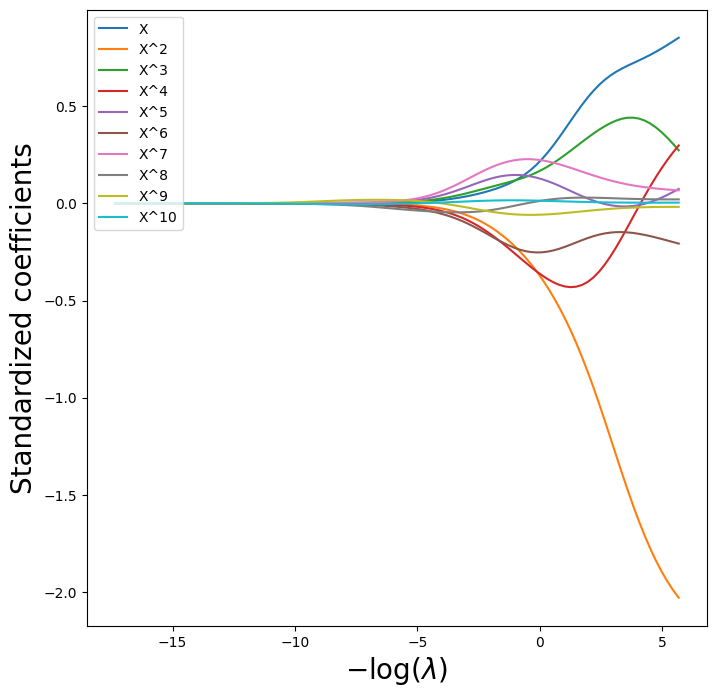

In [166]:
#Graph coefficients for the whole solution path
path_fig, ax = subplots(figsize=(8,8))
soln_path.plot(ax=ax, legend=False)
ax.legend(loc='upper left')
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Standardized coefficients', fontsize=20);


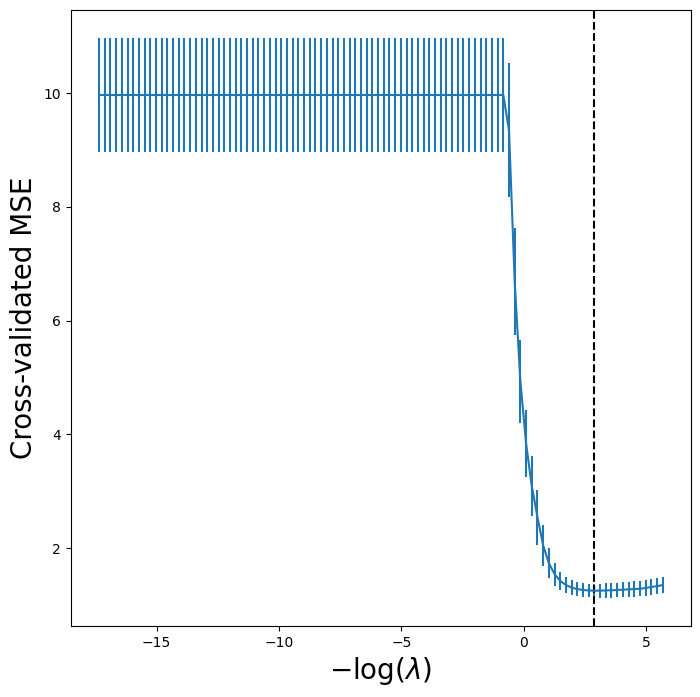

In [167]:
#Graph MSEs for the entire search grid (grid of lambdas/alphas)
est_lasso = est.named_steps['lasso']
lassoCV_fig, ax = subplots(figsize=(8,8))
ax.errorbar(-np.log(est_lasso.alphas_),
            est_lasso.mse_path_.mean(1),
            yerr=est_lasso.mse_path_.std(1) / np.sqrt(K))
ax.axvline(-np.log(est_lasso.alpha_), c='k', ls='--')
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated MSE', fontsize=20);

In [158]:
#Print coefficients for the tuned model
est_lasso.coef_


array([ 0.81568949, -2.54809942,  1.66115008, -0.        ,  0.        ,
       -0.        ,  0.        ,  0.        ,  0.        ,  0.        ])

The coefficients of the selected/trained model are only significant for $X$, $X^2$ and $X^3$, which makes sense given that the data were generated from a polynomial of degree 3. 

**(d) Now generate a response vector `Z` according to the model $Z =  \beta_0 + \beta_5X^5 + \epsilon$,
and perform the lasso on it with the same predictors as before. Discuss the results obtained.**

In [178]:
#Generate z
z = x**5 + rng.normal(size=100)

In [180]:

# Obtain MSE from validation set using outer split
results = skm.cross_validate(pipeCV, 
                             X,
                             z,
                             cv=outer_valid,
                             scoring='neg_mean_squared_error',
                             return_estimator=True) #Add this line to store estimator results (to print selected alpha below)

print(-results['test_score']) 

est = results['estimator'][0] #Store estimation results in object est and print alpha (here [0] is the index of the trained model: only 1 model trained by outer_valid, index = 0)
selected_alpha = est.named_steps['lasso'].alpha_
print("Selected λ (alpha):", selected_alpha)

print("Coefficients from selected model:", est.named_steps['lasso'].coef_)

[1.32121461]
Selected λ (alpha): 0.17846532348110297
Coefficients from selected model: [ 0.          0.          0.          0.         17.03696665  0.
  0.          0.          0.          0.        ]


All the coefficients are set to exactly zero except for the coefficient on $X^5$, which is consistent with the functional form of the function which generated z.